<a href="https://colab.research.google.com/github/lcipolina/MLC_A3C/blob/main/Copy_of_AC3_Ray_RLLIb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Demo of Ray's RLLib

We show how to train a reinforcement learning environment that has been built on top of OpenAI Gym using Ray and RLlib.

In [1]:
# Importing the usuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import sklearn
import json  #to convert result files into Json
import sys, os

# just to display my images
import cv2  
from google.colab.patches import cv2_imshow

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [4]:
import os
import Box2D
import pyglet
import imageio
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [5]:
# Gym RL algos will be running under the hood
!pip install gym
import gym

### RLLib in Ray
Ray comes with many popular DRL models already coded (they are wrapped from Gym), so we are using a “packaged” A3C from RLLIB, we don’t have to code anything ourselves.

In [ ]:
!pip install ray[rllib]
!pip install 'ray[default]'

#Warning: Given that we are executing our examples in Colab we need to restart the runtime after installing ray package

Define directory for checkpoints
 
 Checkpoints are used for the Rollouts of the policy after training or to resume training.

In [7]:
import shutil

#Main saving directory
CHECKPOINT_ROOT = "tmp/a3c/lunar"

# Where checkpoints are written:
shutil.rmtree(CHECKPOINT_ROOT, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = os.getenv("HOME") + "/ray_results/"
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

### Initializing Ray for laptop use (without cluster)

In the Ray initialization command is where we define the parallelization

In [8]:
import ray
#import ray.rllib.agents.ppo as ppo #Import RL model to use (pre-built on RLLIB)

import ray.rllib.agents.a3c as a3c
ray.shutdown()
ray.init(ignore_reinit_error=True)

#NOTE: It prints the dashboard running on a local port

2021-10-30 09:52:56,223	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265


{'metrics_export_port': 65455,
 'node_id': '84c155fcd5ed074e8bb44b747f47800e62892b62d15e28d030d81fa3',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-10-30_09-52-53_834944_1026/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-10-30_09-52-53_834944_1026/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-10-30_09-52-53_834944_1026',
 'webui_url': '127.0.0.1:8265'}

### Gym Environment Configuration in RLLib

RLLib supports several environments: https://docs.ray.io/en/master/rllib-env.html

Here we will train a policy with PPO using Gym's Carpole environment

In [9]:
# Env Configuration
SELECT_ENV = "LunarLander-v2"                      # Specifies the OpenAI Gym environment for Cart Pole

# PPO parameters are passed in a Config dict
config = a3c.DEFAULT_CONFIG.copy()              # PPO's default configuration. See the next code cell.
config["log_level"] = "WARN"                    # Suppress too many messages, but try "INFO" to see what can be printed.

The general synthax for RLLib envs is to instantiate the class with parameters into a Congfig Dict

```
ray.init()
trainer = ppo.PPOTrainer(env=MyEnv, config={
    "env_config": {},  # config to pass to env class
      })
```




In [10]:
# Initializes the training class and object
agent = a3c.A3CTrainer(config, env=SELECT_ENV)

2021-10-30 09:52:58,429	INFO trainer.py:741 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-10-30 09:52:58,432	INFO trainer.py:760 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-30 09:53:09,576	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-30 09:53:09,587	INFO trainable.py:112 -- Trainable.setup took 11.160 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-10-30 09:53:09,590	WARNING util.py:57 -- Install gputil for GPU system monitoring.


### Training
Results are saved at: root/ray_results

In [11]:
# Training
N_ITER = 200 #only 3 iterations to show the idea   (By default, training runs for 10 iterations).
s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} saved {}"

for n in range(N_ITER):
  result = agent.train()                   # each call to agent.train() returns a object containing information that we will inspect below
  file_name = agent.save(CHECKPOINT_ROOT) 

  #Print training stats
  print(s.format(
    n + 1,
    result["episode_reward_min"],
    result["episode_reward_mean"],
    result["episode_reward_max"],
    result["episode_len_mean"],
    file_name
   ))

  1 reward    nan/   nan/   nan len    nan saved tmp/a3c/lunar/checkpoint_000001/checkpoint-1
  2 reward -445.91/-269.83/-81.73 len  96.63 saved tmp/a3c/lunar/checkpoint_000002/checkpoint-2
  3 reward -661.16/-364.29/-81.73 len  94.69 saved tmp/a3c/lunar/checkpoint_000003/checkpoint-3
  4 reward -743.96/-392.93/-81.73 len  92.10 saved tmp/a3c/lunar/checkpoint_000004/checkpoint-4
  5 reward -766.74/-387.27/-13.26 len  95.17 saved tmp/a3c/lunar/checkpoint_000005/checkpoint-5
  6 reward -766.74/-394.93/-13.26 len  99.41 saved tmp/a3c/lunar/checkpoint_000006/checkpoint-6
  7 reward -914.42/-422.20/-13.26 len 104.42 saved tmp/a3c/lunar/checkpoint_000007/checkpoint-7
  8 reward -914.42/-467.56/-13.26 len 107.19 saved tmp/a3c/lunar/checkpoint_000008/checkpoint-8
  9 reward -914.42/-481.65/-13.26 len 110.61 saved tmp/a3c/lunar/checkpoint_000009/checkpoint-9
 10 reward -914.42/-488.12/-13.26 len 116.04 saved tmp/a3c/lunar/checkpoint_000010/checkpoint-10
 11 reward -914.42/-483.62/-13.26 len 122

In [12]:
#https://github.com/anyscale/academy/blob/main/ray-rllib/explore-rllib/01-Application-Cart-Pole.ipynb

# Similarly, we can save the training stats on list to inspect
results = []
episode_data = []
episode_json = []

for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean':result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean':   result['episode_len_mean']}
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    file_name = agent.save(CHECKPOINT_ROOT)
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

  0: Min/Mean/Max reward: -268.9696/-101.7669/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000201/checkpoint-201
  1: Min/Mean/Max reward: -268.9696/-101.7669/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000202/checkpoint-202
  2: Min/Mean/Max reward: -268.9696/-98.5094/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000203/checkpoint-203
  3: Min/Mean/Max reward: -268.9696/-96.3411/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000204/checkpoint-204
  4: Min/Mean/Max reward: -268.9696/-95.0554/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000205/checkpoint-205
  5: Min/Mean/Max reward: -268.9696/-95.1753/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000206/checkpoint-206
  6: Min/Mean/Max reward: -268.9696/-94.1470/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000207/checkpoint-207
  7: Min/Mean/Max reward: -268.9696/-94.5182/138.5827. Checkpoint saved to tmp/a3c/lunar/checkpoint_000208/checkpoint-208
  8: Min/Mean/Max rewa

### Tensorboard

In [19]:
%tensorboard --logdir /root/ray_results

Reusing TensorBoard on port 6006 (pid 349), started 1:37:16 ago. (Use '!kill 349' to kill it.)

<IPython.core.display.Javascript object>

### Inspect Training results

In [14]:
# Inspect the results object
results

[{'agent_timesteps_total': 0,
  'config': {'_fake_gpus': False,
   '_tf_policy_handles_more_than_one_loss': False,
   'action_space': None,
   'actions_in_input_normalized': False,
   'batch_mode': 'truncate_episodes',
   'callbacks': ray.rllib.agents.callbacks.DefaultCallbacks,
   'clip_actions': False,
   'clip_rewards': None,
   'collect_metrics_timeout': 180,
   'compress_observations': False,
   'create_env_on_driver': False,
   'custom_eval_function': None,
   'custom_resources_per_worker': {},
   'eager_tracing': False,
   'entropy_coeff': 0.01,
   'env': 'LunarLander-v2',
   'env_config': {},
   'env_task_fn': None,
   'evaluation_config': {},
   'evaluation_interval': None,
   'evaluation_num_episodes': 10,
   'evaluation_num_workers': 0,
   'evaluation_parallel_to_training': False,
   'exploration_config': {'type': 'StochasticSampling'},
   'explore': True,
   'extra_python_environs_for_driver': {},
   'extra_python_environs_for_worker': {},
   'fake_sampler': False,
   'fram

In [15]:
# Convert to df and inspect
df = pd.DataFrame(data=episode_data)
df

,n,episode_reward_min,episode_reward_mean,episode_reward_max,episode_len_mean
0,0,-268.96956,-101.766928,138.582719,323.94
1,1,-268.96956,-101.766928,138.582719,323.94
2,2,-268.96956,-98.509393,138.582719,337.27
3,3,-268.96956,-96.341148,138.582719,329.08
4,4,-268.96956,-95.055361,138.582719,330.53
...,...,...,...,...,...
195,195,-228.60796,4.163112,231.133030,649.66
196,196,-228.60796,5.524535,231.133030,639.98
197,197,-228.60796,10.673371,231.133030,642.35
198,198,-228.60796,6.554903,231.133030,644.23


Plot results

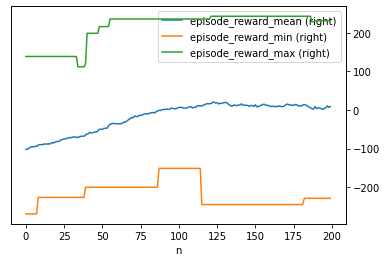

In [16]:
df.plot(x="n", y=["episode_reward_mean", "episode_reward_min", "episode_reward_max"], secondary_y=True)

### Print out the policy and model to see the results of training in detail…

In [17]:
import pprint

policy = agent.get_policy()
model = policy.model

pprint.pprint(model.variables())
pprint.pprint(model.value_function())

print(model.base_model.summary())

[<tf.Variable 'default_policy/fc_1/kernel:0' shape=(8, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/kernel:0' shape=(256, 256) dtype=float32>,
 <tf.Variable 'default_policy/fc_2/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/kernel:0' shape=(256, 4) dtype=float32>,
 <tf.Variable 'default_policy/fc_out/bias:0' shape=(4,) dtype=float32>,
 <tf.Variable 'default_policy/value_out/kernel:0' shape=(256, 1) dtype=float32>,
 <tf.Variable 'default_policy/value_out/bias:0' shape=(1,) dtype=float32>]
<tf.Tensor 'Reshape:0' shape=(?,) dtype=float32>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 8)]          0                                            
___________________________________

### Model Rollout

Once we have trained a policy, we deploy it in the environment.

A 'Rollout' is the application of the trained policy to the environment. This is, for a given state, the policy function will output the best action to take.

****************************************************************************

WARNING: The rllib rollout command discussed next won't work in a cloud environment, because it attempts to pop up a window.


https://docs.ray.io/en/latest/rllib-concepts.html#policy-evaluation

***************************************************************************


.

Next we'll use the RLlib rollout CLI, to evaluate the trained policy.

This visualizes the CartPole agent operating within the simulation: moving the cart left or right to avoid having the pole fall over.

We'll use the last saved checkpoint, checkpoint_10 (or whatever you set for N_ITER above) for the rollout, evaluated through 2000 steps.

    Notes:

        If you changed checkpoint_root above to be different than tmp/ppo/cart, then change it here, too. Note that bugs in variable substitution in Jupyter notebooks, we can't use variables in the next cell, unfortunately.
        If you changed the model parameters, specifically the fcnet_hiddens array in the config object above, make the same change here.

You may need to make one more modification, depending on how you are running this tutorial:

    Running on your laptop? - Remove the line --no-render.
    Running on the Anyscale Service? The popup windows that would normally be created by the rollout can't be viewed in this case. Hence, the --no-render flag suppresses them. The code cell afterwords provides a sample video. You can try adding --video-dir tmp/ppo/cart, which will generate MP4 videos, then download them to view them. Or copy the Video cell below and use it to view the movies.


In [18]:
# On the command line, run the following:

#!rllib rollout\
# tmp/ppo/cart/checkpoint_10/checkpoint-10 \
#    --config "{\"env\": \"CartPole-v1\", \"model\": {\"fcnet_hiddens\": [100, 50]}}" \
#    --run PPO \
#     --steps 2000

### Tensorboard results
Note: one can also use WandB

In [19]:
#From command line:
#tensorboard - logdir=$HOME/ray_results/

### Shut down the service

In [20]:
#ray.shutdown()

## Ray Paralellization

https://github.com/anyscale/academy/blob/64b5b7d149d1dfd3883948bbde0a247b57fbef0c/ray-rllib/explore-rllib/01-Application-Cart-Pole.ipynb

https://towardsdatascience.com/reinforcement-learning-frameworks-e349de4f645a

TL,DR:

RAY basically triggers several ROLLOUTS (i.e. episodes) at the same time (by distributing it to many “WORKERS”) so the whole thing runs faster. "Rollout workers" collect data in mini batches, then a central worker aggregates these into a single batch of data.

LONG ANSWER: https://arxiv.org/pdf/1712.09381.pdf

Ray implements a "centralized parallelization" where there is a *central scheduler* that sends instructions to the *remote workers*. These workers can, for example, explore the environment and collect rewards (distributed sampling), then the centralized agent will optimize the policy, update parameters, handle the replay buffer, etc.

More on Ray Parallelization, at the end of:

https://github.com/anyscale/academy/blob/64b5b7d149d1dfd3883948bbde0a247b57fbef0c/ray-rllib/02-Introduction-to-RLlib.ipynb
.

.
### Parallelization parameters:

```
num_workers -  is the number of actors that the agent will create. It sets the number of CPU processors for parallelization, which determines the degree of parallelism that will be used. In a cluster, these actors will be spread over the available nodes.

model  - contains a dictionary of parameters describing the neural net used to parameterize the policy. The fcnet_hiddens parameter is a list of the sizes of the hidden layers. Here, we have two hidden layers of size 100, each.
```


In short, the entire Ray code for PPO is like this:

In [21]:
import ray
from ray.rllib import agents

#Initialize service and pass the number of resources available
ray.init(num_cpus = 1,
         num_gpus = 0,
         ignore_reinit_error = True)


config = {'gamma': 0.9,
          'lr': 1e-2,
          'num_workers':0, #if we set this to 1, we will pin one worker per core, if we set it to 0, it will utilize several workers per core (workers = process)
          'train_batch_size': 1000,
          'model': {
              'fcnet_hiddens': [128, 128]
          }}

trainer = agents.ppo.PPOTrainer(env='LunarLander-v2', config=config)
results = trainer.train()   

2021-10-30 09:36:34,810	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-30 09:36:39,522	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-30 09:36:39,540	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2021-10-30 09:36:41,791	WARNING deprecation.py:39 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


### Additional parameters we can pass to the config dict

If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

```
num_sgd_iter -  is the number of epochs of SGD (stochastic gradient descent, i.e., passes through the data) that will be used to optimize the PPO surrogate objective at each iteration of PPO, for each minibatch ("chunk") of training data. Using minibatches is more efficient than training with one record at a time.

sgd_minibatch_size  - is the SGD minibatch size (batches of data) that will be used to optimize the PPO surrogate objective.

num_cpus_per_worker  - when set to 0 prevents Ray from pinning a CPU core to 
each worker, which means we could run out of workers in a constrained environment like a laptop or a cloud VM.
```

In [22]:
config = a3c.DEFAULT_CONFIG.copy()              # default configuration. 
config["log_level"] = "WARN"                    # Suppress too many messages, but try "INFO" to see what can be printed.

# Other settings we might adjust:
config["num_workers"] = 1                       # Use > 1 for using more CPU cores, including over a cluster
config["num_sgd_iter"] = 10                     # Number of SGD (stochastic gradient descent) iterations per training minibatch.
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
config["sgd_minibatch_size"] = 250              # The amount of data records per minibatch
config["model"]["fcnet_hiddens"] = [100, 50]    # Neural network with two hidden layers, the list contains the number of weights on each layer
config["num_cpus_per_worker"] = 0               # This avoids running out of resources in the notebook environment when this cell is re-executed

With the above configs, we can train again:

In [24]:
agent = a3c.a3cTrainer(config, env=SELECT_ENV)

results = []
episode_data = []
episode_json = []

for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    file_name = agent.save(CHECKPOINT_ROOT)
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

AttributeError: ignored

### Load from Checkpoint

In [ ]:
# Bring the model config
trained_config = config.copy()

# Load trained model
test_agent = ppo.PPOTrainer(trained_config, SELECT_ENV) #initialize object
test_agent.restore(file_name)  #above we have defined: file_name = agent.save(CHECKPOINT_ROOT)

Example of rollout: 

Reuse the trained policy to act in an environment
The line: `test_agent.compute_action(state)` uses the trained policy to pick an action given the state.

The reward received should match the training reward

In [ ]:
env   = gym.make(SELECT_ENV)
state = env.reset()
done  = False
cumulative_reward = 0

while not done:
  action = test_agent.compute_single_action(state) #gets the next action given a state
  state, reward, done, _ = env.step(action)
  cumulative_reward += reward

print(cumulative_reward)  


### Use Ray Tune for the Parameters 
Now we will use DQN
and Ray Tune runner to train the algo

https://www.codeproject.com/Articles/5271939/Cartpole-The-Hello-World-of-Reinforcement-Learning

In [ ]:
from ray import tune
from ray.rllib.agents.dqn import DQNTrainer
from ray.tune import CLIReporter
from ray.tune.progress_reporter import JupyterNotebookReporter

ray.shutdown()
ray.init(
    ignore_reinit_error=True
)

ENV = 'CartPole-v0'
TARGET_REWARD = 195  #it stops when this reward has been achieved
TRAINER = DQNTrainer

# TRAINING PARAMETERS
#Stopping criteria
stop_dict ={"training_iteration": 3,
            "timesteps_total"   : 5,
            "episode_reward_mean": TARGET_REWARD # stop as soon as we "solve" the environment            
            }  

# Parameters for the trainer function - if we use PPO, we can add the Net layers here as above
config_dict = { "env": ENV,
                "num_workers": 0,  # run in a single process
                "num_gpus": 0
                }

# Runner
analysis =  tune.run(
              TRAINER,
              stop  = stop_dict,
              config= config_dict,
              progress_reporter=JupyterNotebookReporter(overwrite=False),
              verbose=2 #can be changed
          )

Analyse the training results

In [ ]:
df = analysis.dataframe()
df

## Next Steps:
Custom Gym environments and RLLIB

https://medium.com/distributed-computing-with-ray/anatomy-of-a-custom-environment-for-rllib-327157f269e5

https://developpaper.com/ray-and-rllib-for-fast-parallel-reinforcement-learning/

https://towardsdatascience.com/ray-and-rllib-for-fast-and-parallel-reinforcement-learning-6d31ee21c96c

Example of custom environments and reward shaping

https://colab.research.google.com/github/valin1/rllib-tutorial/blob/master/RLlib_Tutorial.ipynb

https://colab.research.google.com/github/ray-project/tutorial/blob/master/rllib_exercises/rllib_colab.ipynb